In [ ]:
import pandas as pd
import altair as alt
import time

import warnings 
warnings.filterwarnings('ignore')
alt.renderers.enable("png")

import requests
from bs4 import BeautifulSoup

from datetime import datetime
from urllib.parse import urljoin
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

In [ ]:
# First, get the url
url = 'https://oig.hhs.gov/fraud/enforcement/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'lxml')

# Initialize lists to store extracted information
titles = []
dates = []
categories = []
links = []

# Find each enforcement action entry
for item in soup.find_all('li', class_ = 'usa-card card--list pep-card--minimal mobile:grid-col-12'):
    # Extract title and link
    title_tag = item.find('h2', class_ = 'usa-card__heading').find('a')
    title = title_tag.text.strip()
    link = title_tag['href']
    
    titles.append(title)
    links.append(f'https://oig.hhs.gov{link}')  # form the full url

    # Extract date
    date = item.find('span', class_ = 'text-base-dark padding-right-105').text.strip()
    dates.append(date)

    # Extract category
    category_tag = item.find('ul', class_ = 'display-inline add-list-reset').find('li')
    category = 'N/A'
    category = category_tag.text.strip()
    categories.append(category)
    data = pd.DataFrame({
    'Title': titles,
    'Date': dates,
    'Category': categories,
    'Link': links
})

# Display the dataframe
print(data.head())

                                               Title              Date  \
0  Pharmacist and Brother Convicted of $15M Medic...  November 8, 2024   
1  Boise Nurse Practitioner Sentenced To 48 Month...  November 7, 2024   
2  Former Traveling Nurse Pleads Guilty To Tamper...  November 7, 2024   
3  Former Arlington Resident Sentenced To Prison ...  November 7, 2024   
4  Paroled Felon Sentenced To Six Years For Fraud...  November 7, 2024   

                     Category  \
0  Criminal and Civil Actions   
1  Criminal and Civil Actions   
2  Criminal and Civil Actions   
3  Criminal and Civil Actions   
4  Criminal and Civil Actions   

                                                Link  
0  https://oig.hhs.gov/fraud/enforcement/pharmaci...  
1  https://oig.hhs.gov/fraud/enforcement/boise-nu...  
2  https://oig.hhs.gov/fraud/enforcement/former-t...  
3  https://oig.hhs.gov/fraud/enforcement/former-a...  
4  https://oig.hhs.gov/fraud/enforcement/paroled-...  


In [ ]:
# Part 2: Adding the Agency Name by Crawling Each Link
agencies = []

# Get loop through each detailed page
for link in data['Link']:
    response = requests.get(link)
    detail_soup = BeautifulSoup(response.content, 'lxml')
    agency_name = 'N/A'
    
    # Locate the <ul> tag containing the details
    details_list = detail_soup.find('ul', class_ = 'usa-list usa-list--unstyled margin-y-2')
    if details_list:
        for li in details_list.find_all('li'):
            label_span = li.find('span', class_ = 'padding-right-2 text-base')
            if label_span:
                label_text = label_span.text.strip()
                # Check if the label is "Date:" or "Agency:"
                if label_text == "Agency:":
                    agency_name = label_span.find_next_sibling(text=True).strip()
    # Append extracted data to lists
    agencies.append(agency_name)

# Display the updated DataFrame
data['Agency'] = agencies
print(data.head())

                                               Title              Date  \
0  Pharmacist and Brother Convicted of $15M Medic...  November 8, 2024   
1  Boise Nurse Practitioner Sentenced To 48 Month...  November 7, 2024   
2  Former Traveling Nurse Pleads Guilty To Tamper...  November 7, 2024   
3  Former Arlington Resident Sentenced To Prison ...  November 7, 2024   
4  Paroled Felon Sentenced To Six Years For Fraud...  November 7, 2024   

                     Category  \
0  Criminal and Civil Actions   
1  Criminal and Civil Actions   
2  Criminal and Civil Actions   
3  Criminal and Civil Actions   
4  Criminal and Civil Actions   

                                                Link  \
0  https://oig.hhs.gov/fraud/enforcement/pharmaci...   
1  https://oig.hhs.gov/fraud/enforcement/boise-nu...   
2  https://oig.hhs.gov/fraud/enforcement/former-t...   
3  https://oig.hhs.gov/fraud/enforcement/former-a...   
4  https://oig.hhs.gov/fraud/enforcement/paroled-...   

                   

In [ ]:
# Test code
df_2021 = pd.read_csv("enforcement_actions_year_month.csv")

In [ ]:
print(len(df_2021), 'enforcement actions since January 2021')

earlist_enforcement = df_2021.iloc[-1]
print('The date and details of the earliest enforcement action it scraped is', earlist_enforcement)

2998 enforcement actions since January 2021
The date and details of the earliest enforcement action it scraped is Title       The United States And Tennessee Resolve Claims...
Date                                               2021-01-04
Category                           Criminal and Civil Actions
Link        https://oig.hhs.gov/fraud/enforcement/the-unit...
Agency      U.S. Attorney's Office, Middle District of Ten...
Name: 2997, dtype: object


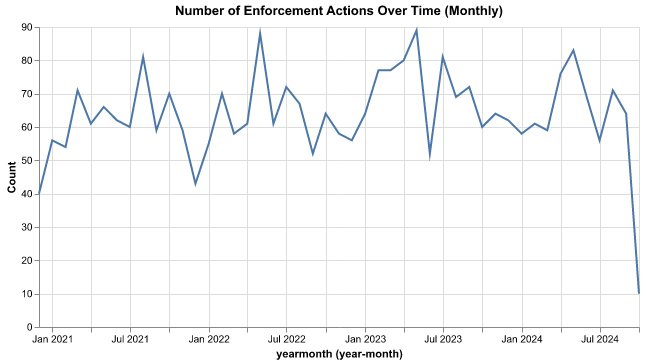

In [ ]:
# Extract year month
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021['yearmonth'] = df_2021['Date'].dt.strftime('%Y-%m')

enforcement_counts = df_2021.groupby('yearmonth').size().reset_index(name = 'Count')

# Convert YearMonth to a string format
enforcement_counts['yearmonth'] = enforcement_counts['yearmonth'].astype(str)

alt.Chart(enforcement_counts).mark_line().encode(
    x = 'yearmonth(yearmonth):T',
    y = 'Count:Q',
    tooltip = ['yearmonth', 'Count']
).properties(
    title = 'Number of Enforcement Actions Over Time (Monthly)',
    width = 600,
    height = 300
)

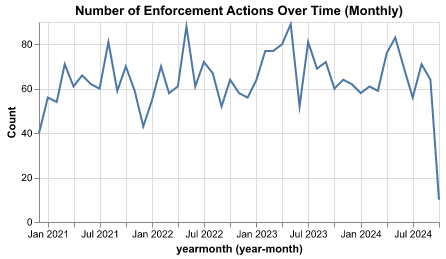

In [ ]:
# Extract year month
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021['yearmonth'] = df_2021['Date'].dt.strftime('%Y-%m')

enforcement_counts = df_2021.groupby('yearmonth').size().reset_index(name = 'Count')

# Convert YearMonth to a string format
enforcement_counts['yearmonth'] = enforcement_counts['yearmonth'].astype(str)

alt.Chart(enforcement_counts).mark_line().encode(
    x = 'yearmonth(yearmonth):T',
    y = 'Count:Q',
    tooltip = ['yearmonth', 'Count']
).properties(
    title = 'Number of Enforcement Actions Over Time (Monthly)',
    width = 400,
    height = 200
)

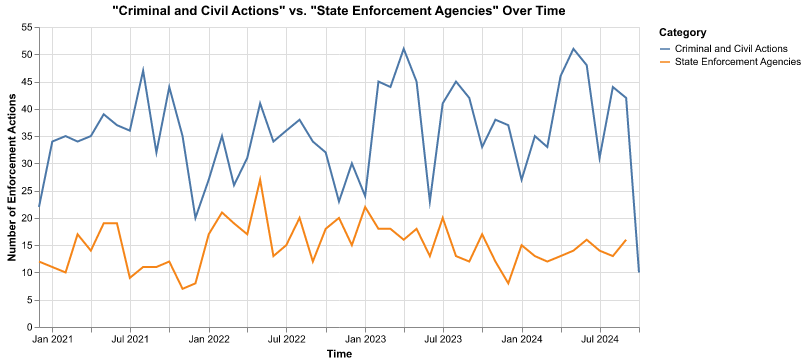

In [ ]:
# Filter the data to include only the two specified categories
filtered_df = df_2021[df_2021['Category'].isin(["Criminal and Civil Actions", "State Enforcement Agencies"])]

# Group by'Category' and count the number of actions 
actions_counts = filtered_df.groupby(['yearmonth','Category']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(actions_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Time'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Category:N',
).properties(
    title = '"Criminal and Civil Actions" vs. "State Enforcement Agencies" Over Time',
    width = 600,
    height = 300
)

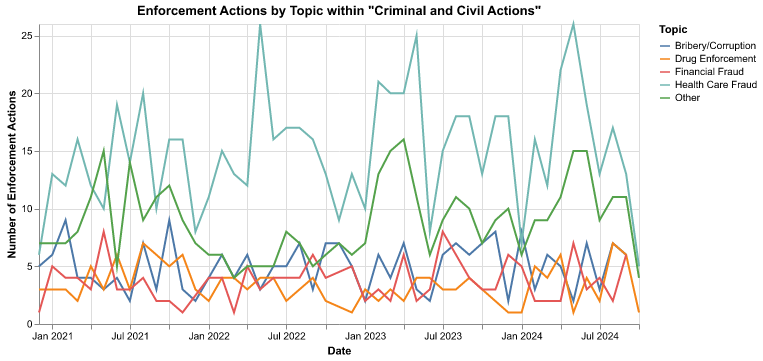

In [ ]:
# Filter to include only "Criminal and Civil Actions" 
five_topics_df = df_2021[df_2021['Category'] == "Criminal and Civil Actions"]

# Define a function to assign topics 
def assign_topic(title):
    title = title.lower()  # Convert to lowercase for case-insensitive matching
    if "bribery" in title or "corruption" in title or "kickback" in title:
        return "Bribery/Corruption"
    elif "financial" in title or "bank" in title or "business" in title or "billing" in title or "money" in title or "investment" in title:
        return "Financial Fraud"
    elif "drug" in title or "opioid" in title or "narcotics" in title:
        return "Drug Enforcement"
    elif "medica" in title or "health" in title:
        return "Health Care Fraud"
    else:
        return "Other"

# Apply the topic assignment function to each title
five_topics_df['Topic'] = five_topics_df['Title'].apply(assign_topic)

# Group by 'yearmonth' and 'Topic' and count the number of actions per topic per month
topic_counts = five_topics_df.groupby(['yearmonth', 'Topic']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(topic_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Date'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Topic:N',
).properties(
    title = 'Enforcement Actions by Topic within "Criminal and Civil Actions"',
    width = 600,
    height = 300
)

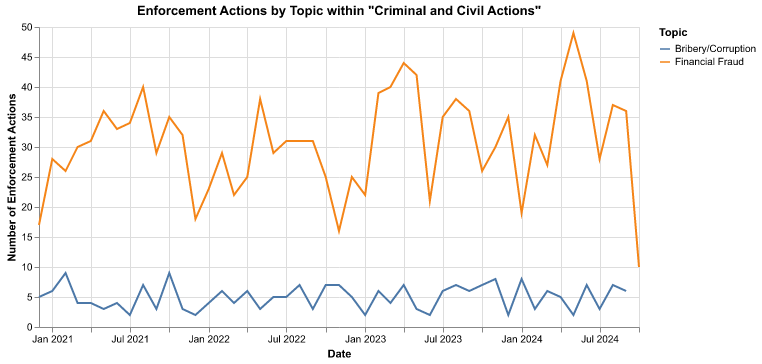

In [ ]:
# Filter to include only "Criminal and Civil Actions" 
five_topics_df = df_2021[df_2021['Category'] == "Criminal and Civil Actions"]

# Define a function to assign topics 
def assign_topic(title):
    title = title.lower()  # Convert to lowercase for case-insensitive matching
    if "bribery" in title or "corruption" in title or "kickback" in title:
        return "Bribery/Corruption"
    elif "financial" in title or "bank":
        return "Financial Fraud"
    elif "drug" in title or "opioid" in title or "narcotics" in title:
        return "Drug Enforcement"
    elif "medica" in title or "health" in title:
        return "Health Care Fraud"
    else:
        return "Other"

# Apply the topic assignment function to each title
five_topics_df['Topic'] = five_topics_df['Title'].apply(assign_topic)

# Group by 'yearmonth' and 'Topic' and count the number of actions per topic per month
topic_counts = five_topics_df.groupby(['yearmonth', 'Topic']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(topic_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Date'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Topic:N',
).properties(
    title = 'Enforcement Actions by Topic within "Criminal and Civil Actions"',
    width = 600,
    height = 300
)

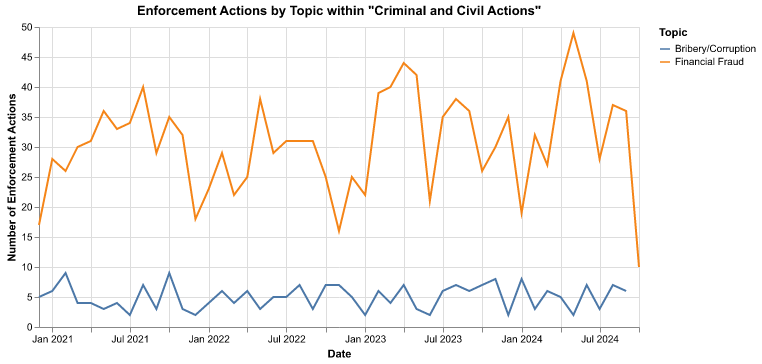

In [ ]:
# Filter to include only "Criminal and Civil Actions" 
five_topics_df = df_2021[df_2021['Category'] == "Criminal and Civil Actions"]

# Define a function to assign topics 
def assign_topic(title):
    title = title.lower()  # Convert to lowercase for case-insensitive matching
    if "bribery" in title or "corruption" in title or "kickback" in title:
        return "Bribery/Corruption"
    elif "financial" in title or "bank":
        return "Financial Fraud"
    elif "drug" in title or "opioid" in title or "narcotics" in title:
        return "Drug Enforcement"
    elif "medica" in title or "health" in title:
        return "Health Care Fraud"
    else:
        return "Other"

# Apply the topic assignment function to each title
five_topics_df['Topic'] = five_topics_df['Title'].apply(assign_topic)

# Group by 'yearmonth' and 'Topic' and count the number of actions per topic per month
topic_counts = five_topics_df.groupby(['yearmonth', 'Topic']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(topic_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Date'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Topic:N',
).properties(
    title = 'Enforcement Actions by Topic within "Criminal and Civil Actions"',
    width = 600,
    height = 300
)

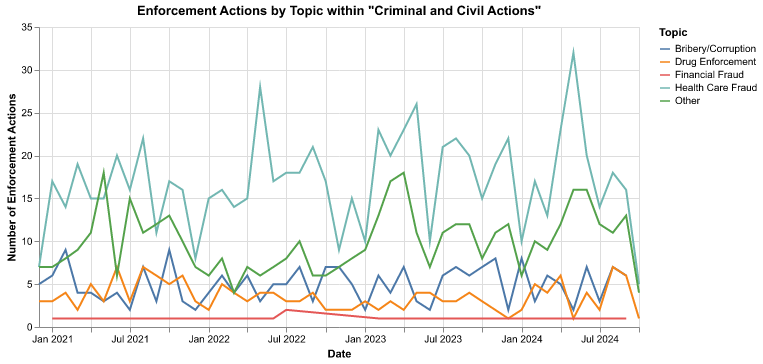

In [ ]:
# Filter to include only "Criminal and Civil Actions" 
five_topics_df = df_2021[df_2021['Category'] == "Criminal and Civil Actions"]

# Define a function to assign topics 
def assign_topic(title):
    title = title.lower()  # Convert to lowercase for case-insensitive matching
    if "bribery" in title or "corruption" in title or "kickback" in title:
        return "Bribery/Corruption"
    elif "financial" in title or "bank" in title :
        return "Financial Fraud"
    elif "drug" in title or "opioid" in title or "narcotics" in title:
        return "Drug Enforcement"
    elif "medica" in title or "health" in title:
        return "Health Care Fraud"
    else:
        return "Other"

# Apply the topic assignment function to each title
five_topics_df['Topic'] = five_topics_df['Title'].apply(assign_topic)

# Group by 'yearmonth' and 'Topic' and count the number of actions per topic per month
topic_counts = five_topics_df.groupby(['yearmonth', 'Topic']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(topic_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Date'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Topic:N',
).properties(
    title = 'Enforcement Actions by Topic within "Criminal and Civil Actions"',
    width = 600,
    height = 300
)

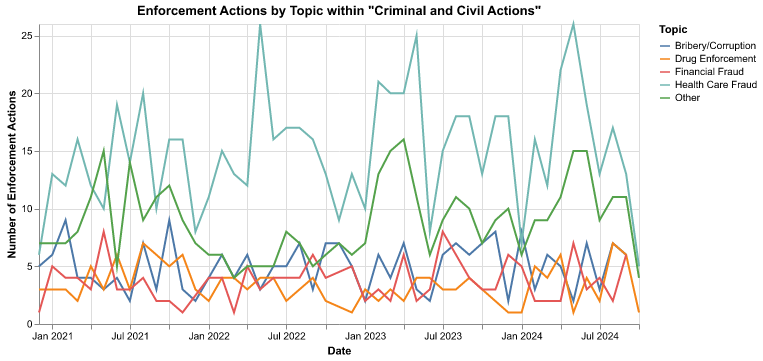

In [ ]:
# Filter to include only "Criminal and Civil Actions" 
five_topics_df = df_2021[df_2021['Category'] == "Criminal and Civil Actions"]

# Define a function to assign topics 
def assign_topic(title):
    title = title.lower()  
    if "bribery" in title or "corruption" in title or "kickback" in title:
        return "Bribery/Corruption"
    elif "financial" in title or "bank" in title or "business" in title or "billing" in title or "money" in title or "investment" in title:
        return "Financial Fraud"
    elif "drug" in title or "opioid" in title or "narcotics" in title:
        return "Drug Enforcement"
    elif "medica" in title or "health" in title:
        return "Health Care Fraud"
    else:
        return "Other"

# Apply the topic assignment function to each title
five_topics_df['Topic'] = five_topics_df['Title'].apply(assign_topic)

# Group by 'yearmonth' and 'Topic' and count the number of actions per topic per month
topic_counts = five_topics_df.groupby(['yearmonth', 'Topic']).size().reset_index(name = 'Count')

# Plotting with Altair
alt.Chart(topic_counts).mark_line().encode(
    x = alt.X('yearmonth(yearmonth):T', title = 'Date'),
    y = alt.Y('Count:Q', title = 'Number of Enforcement Actions'),
    color = 'Topic:N',
).properties(
    title = 'Enforcement Actions by Topic within "Criminal and Civil Actions"',
    width = 600,
    height = 300
)